In [1]:
# Import libraries 
import whitebox
import osgeo.ogr as ogr
import osgeo.osr as osr
import rasterio as rio

from skimage import io
from skimage.filters import gaussian, threshold_sauvola, threshold_local
from skimage.morphology import remove_small_holes,erosion,disk,dilation,remove_small_objects
from skimage.filters import sobel_v, sobel_h
from skimage.transform import hough_line, hough_line_peaks, resize
from skimage.draw import line_aa
from skimage.measure import label, regionprops

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import math
import os

In [2]:
# Geo coordinates to Pixel coordinates.(The order of coordinates:up_left,up_right,low_left,low_right.)
# Perspective Transform.(Note：scikit-image(r,c),opencv(c,r))
def Extract_roi(path,RTK_filepath):
    # Read Geo coords
    Geo_data = pd.read_csv(RTK_filepath,header=None)
    up_left = (Geo_data.iloc[0,2], Geo_data.iloc[0,3])
    up_right = (Geo_data.iloc[1,2], Geo_data.iloc[1,3])
    low_left = (Geo_data.iloc[2,2], Geo_data.iloc[2,3])
    low_right = (Geo_data.iloc[3,2], Geo_data.iloc[3,3])
    # Coordinates Transform.
    # Read GeoTiff
    CHM = rio.open(path,driver="GTiff")
    # Geo coordinates array.
    Geo_coordinates = []
    Geo_coordinates.append(up_left)
    Geo_coordinates.append(up_right)
    Geo_coordinates.append(low_left)
    Geo_coordinates.append(low_right)
    # Pixel coordinates array.
    pixel_coordinates = []
    for n in np.arange(4):
        x, y = Geo_coordinates[n]
        row, col = CHM.index(x, y)
        pixel_coordinates.append((row, col))
    print('pixel_coordinates are:',pixel_coordinates)
    
    # Perspective Transform.
    working_dir,filename = os.path.split(path)
    # Read file
    img = io.imread(path)
    # Calculate the values of row and column.
    columns_1 = np.int(math.sqrt((pixel_coordinates[0][0]-pixel_coordinates[1][0])**2
                                  + (pixel_coordinates[0][1]-pixel_coordinates[1][1])**2))
    columns_2 = np.int(math.sqrt((pixel_coordinates[2][0]-pixel_coordinates[3][0])**2
                                  + (pixel_coordinates[2][1]-pixel_coordinates[3][1])**2))
    columns = np.max((columns_1,columns_2))

    rows_1 = np.int(math.sqrt((pixel_coordinates[0][0]-pixel_coordinates[2][0])**2
                               + (pixel_coordinates[0][1]-pixel_coordinates[2][1])**2))
    rows_2 = np.int(math.sqrt((pixel_coordinates[1][0]-pixel_coordinates[3][0])**2
                               + (pixel_coordinates[1][1]-pixel_coordinates[3][1])**2))
    rows = np.max((rows_1,rows_2))
    # Start Transformation.
    pts1 = np.float32([[pixel_coordinates[0][1],pixel_coordinates[0][0]],
                       [pixel_coordinates[1][1],pixel_coordinates[1][0]],
                       [pixel_coordinates[2][1],pixel_coordinates[2][0]],
                       [pixel_coordinates[3][1],pixel_coordinates[3][0]]])
    pts2 = np.float32([[0,0], [columns,0], [0,rows], [columns, rows]])
    # Transfer matrix.
    Transform_Array = cv2.getPerspectiveTransform(pts1, pts2)
    # Transfer the image.
    Transformed_img = cv2.warpPerspective(img, Transform_Array,(columns, rows))
    
    return(Transformed_img)

In [3]:
# Horizontal&Vertical edges detection.
def Edges_detection(Transformed_img):
    Transformed_img1 = np.array(Transformed_img*255)
    Transformed_img = np.array(Transformed_img*255,dtype='uint8')
    
    # Gaussian filtering to remove interference.
    Transformed_img_gau = gaussian(Transformed_img, sigma=5)
    # Horizontal edge mask.
    threshold_mask = Transformed_img_gau > threshold_sauvola(Transformed_img_gau, window_size=175, k=0.2)
    edges_h = dilation(sobel_h(threshold_mask),disk(6))
    # Vertical edge mask.
    Transformed_img_gau1 = gaussian(Transformed_img1, sigma=5)
    threshold_mask1 = Transformed_img_gau1 > threshold_local(Transformed_img_gau1, 195, 'gaussian')
    mask_v = erosion(remove_small_holes(threshold_mask1,2750),disk(5))
    edges_v = dilation(sobel_v(mask_v),disk(6))

    return(edges_h,edges_v)

In [4]:
def Plot_Mask(edges_h, edges_v, p1, p2):
    # Vertical direction.
    tested_angles = np.linspace(-np.pi/2, np.pi/2, p1)
    h, theta, d = hough_line(edges_v, theta=tested_angles)
    # Horizontal  direction.
    tested_angles1 = np.linspace(-np.pi/2, np.pi/2, p2)
    h1, theta1, d1 = hough_line(edges_h, theta=tested_angles1)
    
    # Creat grid image.
    blank_img = np.zeros((Transformed_img.shape[0],Transformed_img.shape[1]))
    Grid_image = blank_img.copy()
    tmp_line_img = blank_img.copy()

    height = Transformed_img.shape[0]
    width = Transformed_img.shape[1]

    # Vertical direction.
    hspace, angles, distances = hough_line_peaks(h, theta, d)
    distances_v = []
    for angle, dist in zip(angles, distances):
        # Filter out vertical lines.
        if (np.cos(angle)>0.99999):
            distance_v = np.abs(dist)
            distances_v.append(distance_v)
    # Filter out lines that are too close.
    distances_v = np.hstack((distances_v,Transformed_img.shape[1]))
    distances_v = np.sort(np.hstack((distances_v,10)))
    D_value = np.diff(distances_v)
    distances_v_refined = []
    for i in range(distances_v.shape[0]-1):
        if distances_v[i+1]-distances_v[i] < np.max(D_value)*0.75:
            distances_v[i+1] = distances_v[i]
        elif distances_v[i+1]-distances_v[i] >= np.max(D_value)*0.75:
            distances_v_refined.append(distances_v[i])
    distances_v_refined.append(Transformed_img.shape[1]-10)
    num = np.arange(len(distances_v_refined))
    for n, dist_v in zip(num, distances_v_refined):
        rr, cc, val = line_aa(0, np.int(dist_v)-1, height-1, np.int(dist_v)-1)
        tmp_line_img[rr, cc] = val * 1
        Grid_image = np.logical_or(Grid_image,tmp_line_img)
        
    # Horizontal  direction.
    hspace1, angles1, distances1 = hough_line_peaks(h1, theta1, d1)
    distances_h = []
    for angle1, dist1 in zip(angles1, distances1):
        # Filter out horizontal lines.
        if (np.cos(angle1)<0.1):
            distance_h = np.abs(dist1)
            distances_h.append(distance_h)
    # Filter out lines that are too close.
    distances_h = np.hstack((distances_h,Transformed_img.shape[0]))
    distances_h = np.sort(np.hstack((distances_h,10)))
    D_value1 = np.diff(distances_h)
    distances_h_refined = []
    for i in range(distances_h.shape[0]-1):
        if distances_h[i+1]-distances_h[i] < np.max(D_value1)*0.8:
            distances_h[i+1] = distances_h[i]
        elif distances_h[i+1]-distances_h[i] >= np.max(D_value1)*0.8:
            distances_h_refined.append(distances_h[i])
    distances_h_refined.append(Transformed_img.shape[0]-10)
    num1 = np.arange(len(distances_h_refined))
    for n1, dist_h in zip(num1, distances_h_refined):
        rr, cc, val = line_aa(np.int(dist_h)-1, 0, np.int(dist_h)-1, width-1)
        tmp_line_img[rr, cc] = val * 1
        Grid_image = np.logical_or(Grid_image,tmp_line_img)
    
    Grid_Image = dilation(Grid_image, disk(7))
    Grid_Segment = np.logical_not(Grid_Image)
    Grid_Segment_Refine = erosion(Grid_Segment, disk(3))
    # remove minimal area.
    minimal_area = int(np.max(D_value)*np.max(D_value1)*0.2)
    Grid_Segment_Refine = remove_small_objects(Grid_Segment_Refine, minimal_area)

    label_img = label(Grid_Segment_Refine)
    mask = np.zeros((Grid_Segment_Refine.shape[0],Grid_Segment_Refine.shape[1]))

    for region in regionprops(label_img):
        minr, minc, maxr, maxc = region.bbox

        roi=Grid_Segment_Refine[int(region.centroid[0])-80:int(region.centroid[0])+80,
               int(region.centroid[1])-130:int(region.centroid[1])+130]

        cv2.rectangle(mask, (int(region.centroid[1])-130,int(region.centroid[0])-80), 
                      (int(region.centroid[1])+130,int(region.centroid[0])+80), 255, -1)
    return(Grid_Segment_Refine,mask)

In [5]:
def Segment_ROI(Grid_Segment_Refine,Transformed_img):
    # Creat a folder for save images.
    folder_path = os.path.join(results_folder, 'plotimages')
    i = 0
    try:
        os.mkdir(folder_path)
    except FileExistsError:
        # Judge folder existence.
        while(os.path.exists(folder_path)):
            i=i+1
            folder_path = os.path.join(results_folder, 'plotimages'+str(i))
        # Creat a folder
        os.mkdir(folder_path)
        
    # Calculate Heights.
    Labelled_Grid_Img = label(Grid_Segment_Refine)
    Centroid_coordinates = []
    for region in regionprops(Labelled_Grid_Img):
        # Getting centroid coordinates.
        Centroid_coordinate = region.centroid
        Centroid_coordinates.append(Centroid_coordinate)
    # Calculate the rows and columns of planting area.
    rows = np.unique(np.array(Centroid_coordinates)[:,0]).shape[0]
    columns = int(len(Centroid_coordinates)/rows)
    # Each wheat plot:(h,w).
    region_h = int((Transformed_img.shape[0]/rows)*0.8)
    region_w = int((Transformed_img.shape[1]/columns)*0.75)
    # Heights.
    weighted_centroid_coords = []
    wheat_mean_heights = []
    for n,region in enumerate(regionprops(Labelled_Grid_Img,Transformed_img)):
        # Getting weighted centroid coordinates.
        weighted_centroid_coord = region.weighted_centroid
        weighted_centroid_coords.append(weighted_centroid_coord)
        # Region area.
        minr = int(weighted_centroid_coord[0] - region_h/2)
        maxr = int(weighted_centroid_coord[0] + region_h/2)
        minc = int(weighted_centroid_coord[1] - region_w/2)
        maxc = int(weighted_centroid_coord[1] + region_w/2)
        roi = Transformed_img[minr:maxr,minc:maxc]
        # This is the region image.
        plot_image = np.array(roi*255,dtype='uint8')
        save_path = os.path.join(folder_path,'plot_'+str(n+1)+'.png')
        io.imsave(save_path,plot_image)
        # Remove outliers.
        roi = roi[roi < 2]
        # Calculate the appropriate height.
        roi_wheat_height = roi[roi > np.percentile(roi,90)]
        # mean
        wheat_mean_height = round(np.mean(roi_wheat_height)*100, 2)
        wheat_mean_heights.append(wheat_mean_height)
    
    # rows&columns
    row_index=[]
    column_index=[]
    for i in range(int(rows)):
        for j in range(int(columns)):
            row_index.append(i+1)
            column_index.append(j+1)
            
    # Write to csv files.
    # Plot traits.
    dt = pd.DataFrame({'row_id':row_index,'column_id':column_index,'Heights':wheat_mean_heights})
    save_path = os.path.join(results_folder,'Heights.csv')
    dt.to_csv(save_path,encoding="gbk")
    
    return(folder_path)

In [6]:
# Choose interested varieties of wheat.
# The order of choosing:up_left,up_right,low_left,low_right.
# event-Operational response event；(x,y)-pixel coordinates；flags-The event of the Mouse；param-A function pointer.
def Segment_point_cloud(img_path, las_path):
    ### Choose regions of interest plots!
    ### Each plot:up_left,up_right,low_left,low_right.
    img = io.imread(img_path)
    img = np.array(img*255,dtype='uint8')
    img = cv2.resize(img,None, fx=0.15, fy=0.15)
    pixel_coords = []
    def OnMouseAction(event, x, y, flags, param):
        # Mouse Action
        if event == cv2.EVENT_LBUTTONDOWN:
            xy = "%d,%d" % (x, y)
            print(xy)
            pixel_coords.append(np.array((y,x)))
            cv2.circle(img, (x, y), 3, (0, 0, 255), thickness = -1)
            cv2.imshow('image', img)
        return(pixel_coords)

    # 'Enter' to finish the event!!!
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', OnMouseAction)
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    ### Creat a folder to save wheat plot point cloud.
    folder_path = os.path.join(results_folder, 'plot_point_cloud')
    i = 0
    try:
        os.mkdir(folder_path)
    except FileExistsError:
        # Judge folder existence.
        while(os.path.exists(folder_path)):
            i=i+1
            folder_path = os.path.join(results_folder, 'plot_point_cloud_'+str(i))
        # Creat a folder
        os.mkdir(folder_path)
    
    ### This step is to begin to segment point cloud.
    CHM = rio.open(img_path,driver="GTiff")
    # Transform Matrix
    transform = CHM.transform
    wbt = whitebox.WhiteboxTools()
    working_dir, filename = os.path.split(las_path)
    wbt.set_working_dir(working_dir)
    wbt.set_verbose_mode(False)
    for i in range(0,int(len(pixel_coords)/4)):
        pixel_coords1 = np.array(pixel_coords[4*i:4*(i+1)])/0.15
        # Geo coords
        up_left = transform * np.array((pixel_coords1[0][1],pixel_coords1[0][0]))
        up_right = transform * np.array((pixel_coords1[1][1],pixel_coords1[1][0]))
        low_left = transform * np.array((pixel_coords1[2][1],pixel_coords1[2][0]))
        low_right = transform * np.array((pixel_coords1[3][1],pixel_coords1[3][0]))
        geo_coords = np.array((up_left,up_right,low_left,low_right))
        # ESRI( Shapefile)，and save it.
        driver = ogr.GetDriverByName("ESRI Shapefile")  
        data_source = driver.CreateDataSource(os.path.join(working_dir, 'polygon.shp'))
        # Creat spatial reference，EPSG Encode（https://epsg.io/）
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(28356)  #Robin LiDAR:GDA94/56,that is 28356.
        #Create a layer with the same name as the registered driver SHP above,Feature Type:MultiPolygon.
        layer = data_source.CreateLayer("polygon.shp", srs, ogr.wkbMultiPolygon)
        feature = ogr.Feature(layer.GetLayerDefn())
        wkt = 'polygon((%f %f,%f %f,%f %f,%f %f,%f %f))' % (
            geo_coords[0][0],geo_coords[0][1],geo_coords[2][0],geo_coords[2][1],geo_coords[3][0],geo_coords[3][1],geo_coords[1][0],
            geo_coords[1][1],geo_coords[0][0],geo_coords[0][1])
        print(wkt)
        polygon = ogr.CreateGeometryFromWkt(wkt)
        feature.SetGeometry(polygon)
        #Creat feature(shapefile).
        layer.CreateFeature(feature)
        feature = None
        data_source = None
        wbt.clip_lidar_to_polygon(
            i=filename, 
            polygons='polygon.shp',
            output=os.path.join(folder_path,'plot_'+str(i+1)+'.las')
        )
        
    return(folder_path)

In [7]:
# Related file path
CHM_dir = r"C:\Users\Pix4D-WS\Desktop\test\CHM.tif"
Geo_coords = r"C:\Users\Pix4D-WS\Desktop\test\Geo_coords.csv"
filtered_dir = r"C:\Users\Pix4D-WS\Desktop\test\filter.las"

# Step 1: Create a folder to save results.
root, filename = os.path.split(filtered_dir)
results_folder = os.path.join(root, 'results')
i = 0
try:
    os.mkdir(results_folder)
except FileExistsError:
    # Judge folder existence.
    while(os.path.exists(results_folder)):
        i=i+1
        results_folder = os.path.join(root, 'results'+str(i))
    # Creat a folder
    os.mkdir(results_folder)

In [8]:
# Step 2: Get the ROI
Transformed_img = Extract_roi(CHM_dir,Geo_coords)

# Save(tif)
Tif_path = os.path.join(results_folder,'Transformed_img.tif')
cv2.imwrite(Tif_path,Transformed_img)
# Save(jpg)
Jpg_path = os.path.join(results_folder,'Transformed_img.jpg')
cv2.imwrite(Jpg_path,Transformed_img*255)

pixel_coordinates are: [(57, 1451), (571, 3785), (6330, 35), (6846, 2366)]


True

In [9]:
# Step 3: Detect Horizontal&Vertical edges
edges_h,edges_v = Edges_detection(Transformed_img)

# Step 4: Create a mask for segmentation.
# It will generate a segmented mask which is saved in the results folder.
Plot_Segment_Refine,mask = Plot_Mask(edges_h, edges_v, 360, 30)
# Save the mask.
cv2.imwrite(os.path.join(results_folder, 'Plot_Segment.jpg'),Plot_Segment_Refine*255)

True

In [10]:
# Step 5: Segment the ROI and save the data of wheat heights.
images_folder = Segment_ROI(Plot_Segment_Refine,Transformed_img)

len(os.listdir(images_folder))

162

In [11]:
# Step 6: Segment plot point cloud.
plot_pointcloud_folder = Segment_point_cloud(CHM_dir, filtered_dir)

len(os.listdir(plot_pointcloud_folder))

141,363
189,376
135,387
178,399
127,429
175,446
121,457
163,469
106,537
147,549
98,564
144,573
polygon((-2161363.780000 13894348.580000,-2161364.180000 13894346.980000,-2161361.313333 13894346.180000,-2161360.580000 13894347.713333,-2161363.780000 13894348.580000))
polygon((-2161364.713333 13894344.180000,-2161365.113333 13894342.313333,-2161362.313333 13894341.513333,-2161361.513333 13894343.046667,-2161364.713333 13894344.180000))
polygon((-2161366.113333 13894336.980000,-2161366.646667 13894335.180000,-2161363.580000 13894334.580000,-2161363.380000 13894336.180000,-2161366.113333 13894336.980000))


3

Text(0.5, 1.0, 'img(jet)')

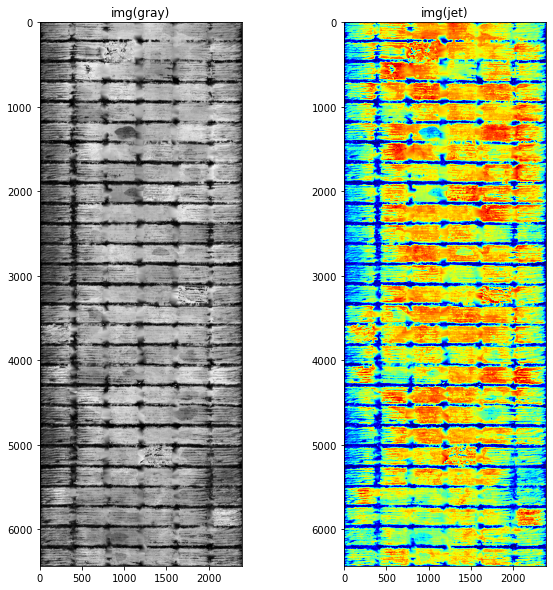

In [12]:
# Visualization: Step 1.
img = np.array(Transformed_img*255,dtype='uint8')

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('img(gray)')
axes[1].imshow(img, cmap=plt.cm.jet)
axes[1].set_title('img(jet)')

Text(0.5, 1.0, 'edges_v')

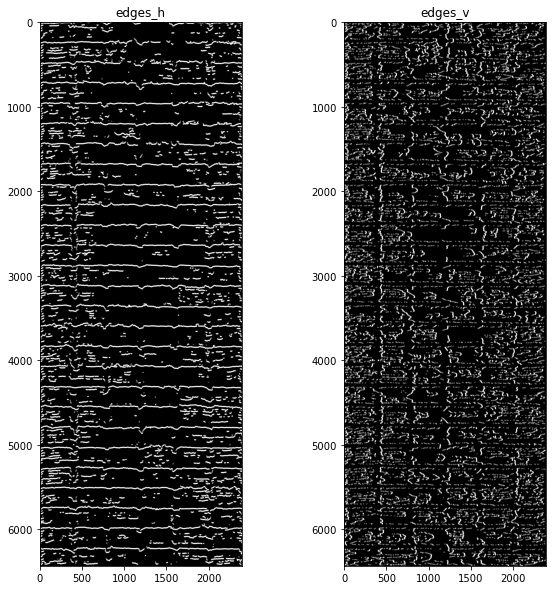

In [13]:
# Visualization: Step 2.
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(edges_h, cmap=plt.cm.gray)
axes[0].set_title('edges_h')
axes[1].imshow(edges_v, cmap=plt.cm.gray)
axes[1].set_title('edges_v')

Text(0.5, 1.0, 'Segment_mask(remove_edges)')

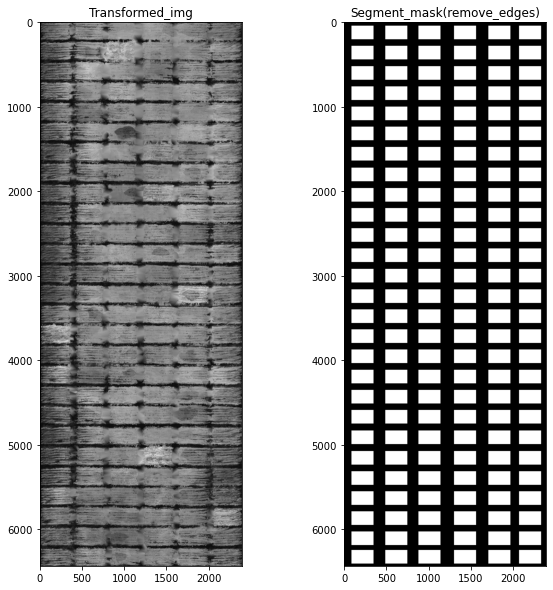

In [15]:
# Visualization: Step 3.
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(Transformed_img, cmap=plt.cm.gray)
axes[0].set_title('Transformed_img')
axes[1].imshow(mask, cmap=plt.cm.gray)
axes[1].set_title('Segment_mask(remove_edges)')